# SoLEXS aboard Aditya-L1: M-class flare from 08 August 2025
[SoLEXS](https://link.springer.com/article/10.1007/s11207-025-02494-0#auth-Abhijit-Adoni-Aff1) 
    is the low-energy (~3-20 keV) spectrometer aboard Aditya-L1.

Here we fit a thermal bremsstrahlung model to SoLEXS SDD2 with varied abundances.
Because the count rate is relatively high,
    we require a gain correction.
The gain shift is implemented by interpolating the count-space model energy bins.
This is distinct from Xspec,
    which interpolates the effective area curve in photon space,
    but the outcome is effectively the same.

First,
    we load in the data and define models.
Then,
    we do some initial gain fits using Levenberg-Marquadt minimization.
Finally, we run MCMC on the parameters to get uncertainties and correlations.

### **Important**: we use a [Negative Binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution#Overdispersed_Poisson) likelihood to fit the data, which acts as a Poisson distribution with extra variance.
This is a nice trick so we don't need to worry about $\chi^2$ biasing with small numbers of bins,
    at least during MCMC.
The Levenberg-Marquadt minimization is inherently biased.
If you want that fit portion to **not** be biased,
    you will need to rebin the data,
    for example using the Gamma-ray Data Tools functions
    for [rebinning response matrices](https://astro-gdt.readthedocs.io/en/stable/api/gdt.core.data_primitives.ResponseMatrix.html#gdt.core.data_primitives.ResponseMatrix.rebin)
    and for [rebinning binned data](https://astro-gdt.readthedocs.io/en/latest/core/binning/binned.html),
    specifically [rebin_by_snr](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.binning.binned.rebin_by_snr.html#gdt.core.binning.binned.rebin_by_snr).

## Fetch SoLEXS data from their [data server](https://pradan.issdc.gov.in/al1/protected/payload.xhtml)
SoLEXS data is served as daily `.zip` files which are further processed in a later step using `solexs-tools`.

We follow the procedures outlined in the [user manual](https://pradan.issdc.gov.in/al1/protected/downloadFile/solexs/SoLEXS-UserManual.pdf)
to select and prepare the data.

The rest of the guide assumes that you have downloaded the data from 2025 August 08.

In [1]:
import os

# Make the thermal emission matrix multiplications
# use fewer CPU cores.
# This can speed up MCMC, ironically.
os.environ["OMP_NUM_THREADS"] = "4"

import pprint
from astropy.io import fits
import astropy.time as atime
import numpy as np
import astropy.units as u

from yaff.extern import solexs
from yaff import common_likelihoods
from yaff import fitting
from yaff import plotting as yap

import matplotlib.pyplot as plt

plt.style.use("nice.mplstyle")

# Silence division errors
_ = np.seterr(divide="ignore", invalid="ignore")

## Read in a light curve file for SDD2 and pick event/background intervals

In [2]:
base = "AL1_SLX_L1_20250808_v1.0/SDD2"
lc_file = "AL1_SOLEXS_20250808_SDD2_L1.lc.gz"
with fits.open(f"{base}/{lc_file}") as lcf:
    lc_dat = lcf[1]
    dt = lc_dat.header["TIMEDEL"] << u.Unit(lc_dat.header["TIMEUNIT"])
    start_time = atime.Time(lc_dat.header["TSTART"], format="unix")
    lightcurve_all_counts = lc_dat.data["COUNTS"].astype(float)
    lightcurve_time_bins = start_time + np.arange(lightcurve_all_counts.size + 1) * dt

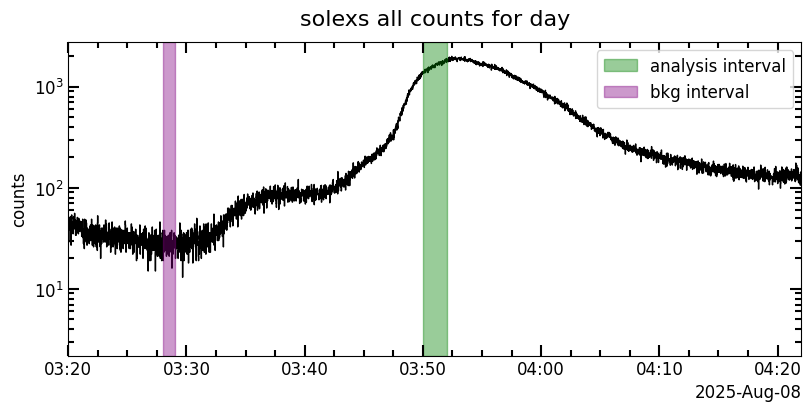

In [3]:
fig, ax = plt.subplots()
ax.stairs(lightcurve_all_counts, lightcurve_time_bins.datetime, color="black")

analysis_interval = atime.Time(["2025-08-08T03:50:00Z", "2025-08-08T03:52:00Z"])
bkg_interval = atime.Time(["2025-08-08T03:28:00Z", "2025-08-08T03:29:00Z"])

ax.axvspan(
    *analysis_interval.datetime, color="green", alpha=0.4, label="analysis interval"
)
ax.axvspan(*bkg_interval.datetime, color="purple", alpha=0.4, label="bkg interval")

# Plot a segment around the interval of interest
plot_buffer = 30 << u.min
ax.set(
    yscale="log",
    ylabel="counts",
    title="solexs all counts for day",
    xlim=(
        (analysis_interval[0] - plot_buffer).datetime,
        (analysis_interval[1] + plot_buffer).datetime,
    ),
)

ax.legend()

plt.show()

## Generate the SoLEXS spectrum and response files
The [`solexs-tools`](https://pradan.issdc.gov.in/al1/protected/downloadFile/solexs/solexs_tools-1.1.tar.gz) package may be downloaded from their data distribution websitie and installed into a Python environment.
The setup is outlined in the [user manual](https://pradan.issdc.gov.in/al1/protected/downloadFile/solexs/SoLEXS-UserManual.pdf).
Install the tools before continuing. It is recommended to use a virtual environment for this purpose.

Using the time intervals we selected before,
you can run the following `bash` snippets to slice the SoLEXS data into spectrum files.
During the slicing,
    the effective area (ARF) and energy redistribution (RMF) file paths will be printed

### Step 1: flare data
```bash
t1="2025-08-08T03:50:00"
t1=$(echo $(solexs-utc2time "$t1") | cut -d' ' -f3)

t2="2025-08-08T03:52:00"
t2=$(echo $(solexs-utc2time "$t2") | cut -d' ' -f3)

# Generate a spectrum from the L1 data files
spec_fn="AL1_SLX_L1_20250808_v1.0/SDD2/AL1_SOLEXS_20250808_SDD2_L1.pi.gz"
gti_fn="AL1_SLX_L1_20250808_v1.0/SDD2/AL1_SOLEXS_20250808_SDD2_L1.gti.gz"

solexs-genspec -i "$spec_fn" \
    -tstart "$t1" -tstop "$t2"\
    -gti "$gti_fn"
```

### Step 2: background data
```bash
t1="2025-08-08T03:28:00"
t1=$(echo $(solexs-utc2time "$t1") | cut -d' ' -f3)

t2="2025-08-08T03:29:00"
t2=$(echo $(solexs-utc2time "$t2") | cut -d' ' -f3)

# Generate a spectrum from the L1 data files
spec_fn="AL1_SLX_L1_20250808_v1.0/SDD2/AL1_SOLEXS_20250808_SDD2_L1.pi.gz"
gti_fn="AL1_SLX_L1_20250808_v1.0/SDD2/AL1_SOLEXS_20250808_SDD2_L1.gti.gz"

solexs-genspec -i "$spec_fn" \
    -tstart "$t1" -tstop "$t2"\
    -gti "$gti_fn"
```

In [4]:
data_fn = "AL1_SOLEXS_20250808_SDD2_L1_225000_225200.pi"
flare_data = solexs.read_counts(data_fn)

bkg_fn = "AL1_SOLEXS_20250808_SDD2_L1_222800_222900.pi"
bkg_data = solexs.read_counts(bkg_fn)

In [5]:
# Now, load in the response data, using the paths output by the SoLEXS tools

arf_fn = "solexs_tools-1.1/CALDB/arf/solexs_arf_SDD2_v1.arf"
rmf_fn = "solexs_tools-1.1/CALDB/response/rmf/solexs_gaussian_SDD2_v1.rmf"

# Put the arf and rmf data into one dict,
# but keep the information separated by keys
response_data = solexs.read_arf(arf_fn) | solexs.read_rmf(rmf_fn)

## Now that the data and response matrices have been loaded, let's define our models.

In [6]:
default_abun_type = "sun_coronal_ext"
atomic_numbers = {"mg": 12, "al": 13, "si": 14, "s": 16, "ar": 18, "ca": 20, "fe": 26}


def thermal_with_relative_abundances(args: dict[str, object]):
    # As of August 2025, there is a bug in sunkit-spex where the
    # abundance table is modified each time a relative abundance is used.
    # So we hack around that here by restoring the original table each iteration
    # of the following model function.
    import copy
    from sunkit_spex.legacy import thermal

    original_abundances = copy.deepcopy(thermal.DEFAULT_ABUNDANCES)

    energies: np.ndarray = args["photon_energy_edges"]
    params: dict[str, fitting.Parameter] = args["parameters"]

    # For every atomic number given,
    # scale the default abundances by the coronal values.
    rel_abuns = list()
    for k, v in params.items():
        if k not in atomic_numbers:
            continue
        rel_abuns.append((atomic_numbers[k], float(v.value)))

    ret = thermal.thermal_emission(
        energies << u.keV,
        temperature=params["temperature"].as_quantity(),
        emission_measure=params["emission_measure"].as_quantity(),
        abundance_type=default_abun_type,
        relative_abundances=rel_abuns,
    ).to_value(u.ph / u.cm**2 / u.keV / u.s)

    # Hack: restore original abundances
    thermal.DEFAULT_ABUNDANCES = original_abundances
    return ret

## After defining the models, set up the data packet for the `yaff.BayesFitter`

In [7]:
# Cut out any photon bins < 1.5 keV
# (thermal emission function doesn't like it)
ph_bins = response_data["photon_energy_bins"]
mids = ph_bins[:-1] + np.diff(ph_bins) / 2

lower_limit = 2.5 << u.keV
keep = mids > lower_limit
keep_edges = ph_bins >= lower_limit

# The background counts need to get scaled by the ratio of effective exposures
# between the observation window and the background window
exposure_scale = bkg_data["exposure"] / flare_data["exposure"]

# Assemble all the data we have for this fit
dp = fitting.DataPacket(
    counts=flare_data["counts"],
    counts_error=flare_data["counts_error"],
    background_counts=bkg_data["counts"] * exposure_scale,
    background_counts_error=bkg_data["counts_error"] * exposure_scale,
    effective_exposure=flare_data["exposure"],
    count_energy_edges=response_data["count_energy_bins"],
    photon_energy_edges=response_data["photon_energy_bins"][keep_edges],
    response_matrix=(
        response_data["effective_area"][keep]
        * response_data["redistribution_matrix"][:, keep]
    ),
)

## Define the parameters and priors (bounds), and instantiate the fitter object
Note that the gain parameters are automatically added when instantiating a `BayesFitterWithGain`.

In [8]:
# Now that the model is set up, define the parameters that we care about.

params = {
    "temperature": fitting.Parameter(20 << u.MK, frozen=False),
    "emission_measure": fitting.Parameter(0.5 << (1e49 * u.cm**-3), frozen=False),
}

log_priors = {
    "temperature": fitting.simple_bounds(4, 30),
    "emission_measure": fitting.simple_bounds(1e-3, 1e3),
}

rng = np.random.default_rng()
# There are a lot of elements we can vary, so add them with a loop.
# You could fit more elements if you want, but you'll need to update the dict above the model.
elemental_params = ["fe", "ca", "ar"]
for n in elemental_params:
    params[n] = fitting.Parameter(1.0 << u.one, frozen=False)
    log_priors[n] = fitting.simple_bounds(0.01, 3.0)

# Fit only above 3, as the response at lower energies
# is not calibrated yet
lowe = 3
mids = dp.count_energy_mids
# Notice we are using a negative binomial likelihood to avoid biasing low-count bins
likelihood = common_likelihoods.negative_binomial_factory(
    restriction=(fit_restriction := (lowe < mids))
)

# Note that we're using a BayesFitterWithGain: it adds in the gain slope/offset params
fr = fitting.BayesFitterWithGain(
    data=dp,
    model_function=thermal_with_relative_abundances,
    parameters=params,
    log_priors=log_priors,
    log_likelihood=likelihood,
)

/home/william/dev/yaff/yaff/fitting.py:559: UserWarning: 
Gain slope and offset parameters/priors added to the parameter/prior ODicts.
  warnings.warn("\nGain slope and offset parameters/priors added to the parameter/prior ODicts.")


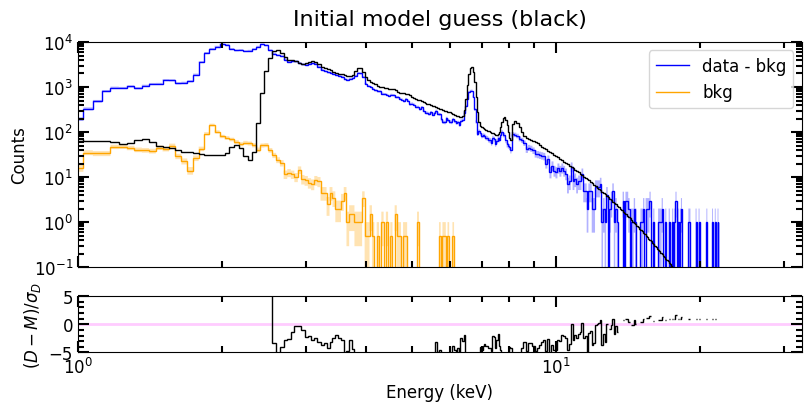

In [9]:
# Let's plot the model just to make sure we have an OK starting guess
# We don't fit below ~2 keV because the response is still being developed.
fig = plt.figure()
ret = yap.plot_data_model(fr, fig=fig)
ret["data_ax"].set_title("Initial model guess (black)")
ret["data_ax"].set(ylim=(0.1, 1e4), xlim=(1, None))
plt.show()

In [10]:
# We want the gain slope and offset to both be free
fr.parameters["gain_slope"].frozen = False
fr.parameters["gain_offset"].frozen = False

pprint.pprint(fr.parameters)

OrderedDict([('temperature', Parameter[2.00e+01, MK, frozen=False]),
             ('emission_measure',
              Parameter[5.00e-01, 1e+49 / cm3, frozen=False]),
             ('fe', Parameter[1.00e+00, , frozen=False]),
             ('ca', Parameter[1.00e+00, , frozen=False]),
             ('ar', Parameter[1.00e+00, , frozen=False]),
             ('gain_slope', Parameter[1.00e+00, , frozen=False]),
             ('gain_offset', Parameter[0.00e+00, keV, frozen=False])])


## We need to be a bit careful when fitting abundances...
Read the comments for more info

In [11]:
# Perform an initial minimization using Levenberg-Marquadt
fr = fitting.levenberg_minimize(
    fr,
    restriction=fit_restriction,
    # Abundances don't make a huge difference on the function evaluations,
    # so give the fitter a little more than default wiggle room
    # so we don't get stuck forever...!
    # (default stopping criteria being [ftol = dF/F = 1e-8])
    ftol=1e-5,
    # A 3-point Jacobian is important for fitting the abundances.
    jac="3-point",
)

In [12]:
# The fit parameters look good
fr.parameters

OrderedDict([('temperature', Parameter[1.84e+01, MK, frozen=False]),
             ('emission_measure',
              Parameter[4.85e-01, 1e+49 / cm3, frozen=False]),
             ('fe', Parameter[4.29e-01, , frozen=False]),
             ('ca', Parameter[8.29e-01, , frozen=False]),
             ('ar', Parameter[1.46e+00, , frozen=False]),
             ('gain_slope', Parameter[9.94e-01, , frozen=False]),
             ('gain_offset', Parameter[1.02e-02, keV, frozen=False])])

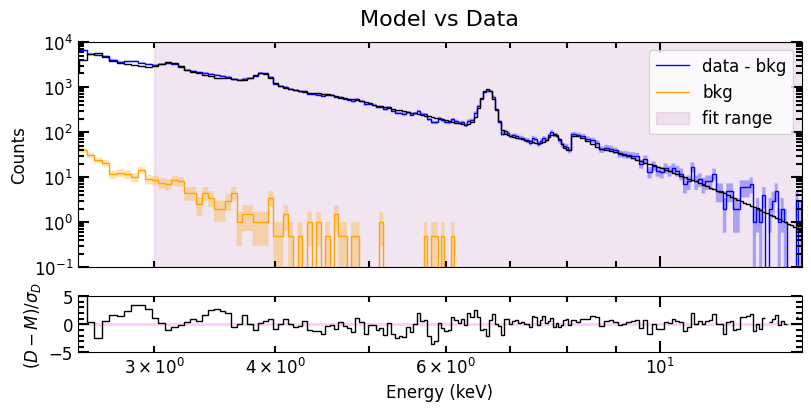

In [13]:
# Plot the fit to see how it looks
fig = plt.figure()
ret = yap.plot_data_model(fr, fig=fig)
ret["data_ax"].axvspan(
    lowe, 30, color="purple", alpha=0.1, zorder=-1, label="fit range"
)
ret["data_ax"].legend()

ret["data_ax"].set(xlim=(2.5, 14), ylim=(0.1, 1e4))
plt.show()

## At this point, the fit looks quite good, but we need uncertainties.
You could obtain estimates on the uncertainties like Xspec by finding the 95% posterior
    contour on the $\chi^2$ statistic.

That's mathematically difficult, and biased when you have few counts per bin.
Instead, let's run MCMC, which will use the negative binomial likelihood defineda above.

In [14]:
# Before running MCMC, freeze the gain parameters (they can go off the rails)
# You could try giving them more restrictive priors, too, instead of just freezing them.
fr.parameters["gain_slope"].frozen = fr.parameters["gain_offset"].frozen = True

fr.run_emcee(emcee_constructor_kw={"nwalkers": 20}, emcee_run_kw={"nsteps": 1000})

100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


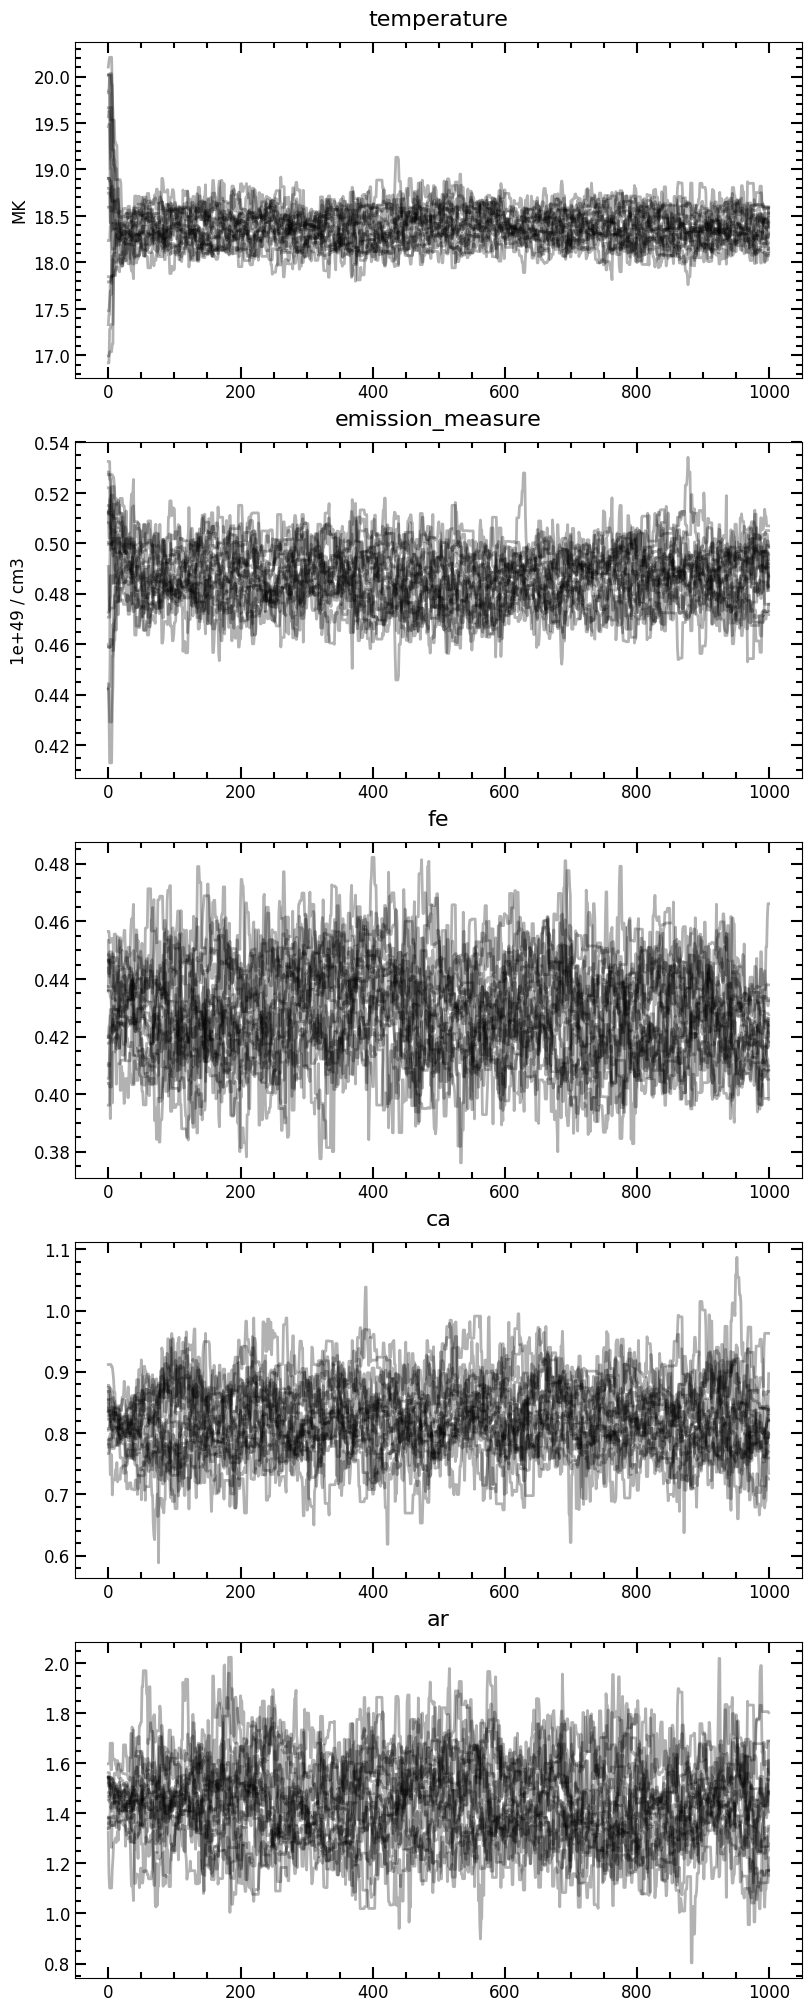

In [15]:
# Plot the parameter chains we got from that MCMC run to see how things turned out
fig = plt.figure(layout="constrained", figsize=(8, 20))
yap.plot_parameter_chains(fr, fr.free_param_names, fr.free_parameters, fig=fig)

# The figure is too large to display; save it to a PNG
fig.savefig("solexs-abundances.png", dpi=300)
plt.show()
plt.close(fig)

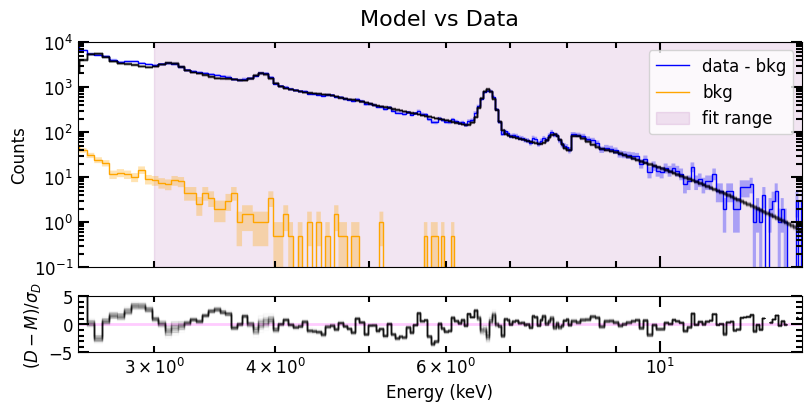

In [16]:
# Let's generate some samples from the MCMC run and plot them over the data.
burn = 20 * fr.emcee_sampler.nwalkers
samples = fr.generate_model_samples(100, burnin=burn)
ret = yap.plot_data_model(fr, samples)
ret["data_ax"].axvspan(
    lowe, 30, color="purple", alpha=0.1, zorder=-1, label="fit range"
)
ret["data_ax"].legend()

ret["data_ax"].set(xlim=(2.5, 14), ylim=(0.1, 1e4))
plt.show()

## The fit looks nice. Let's look at corner plots

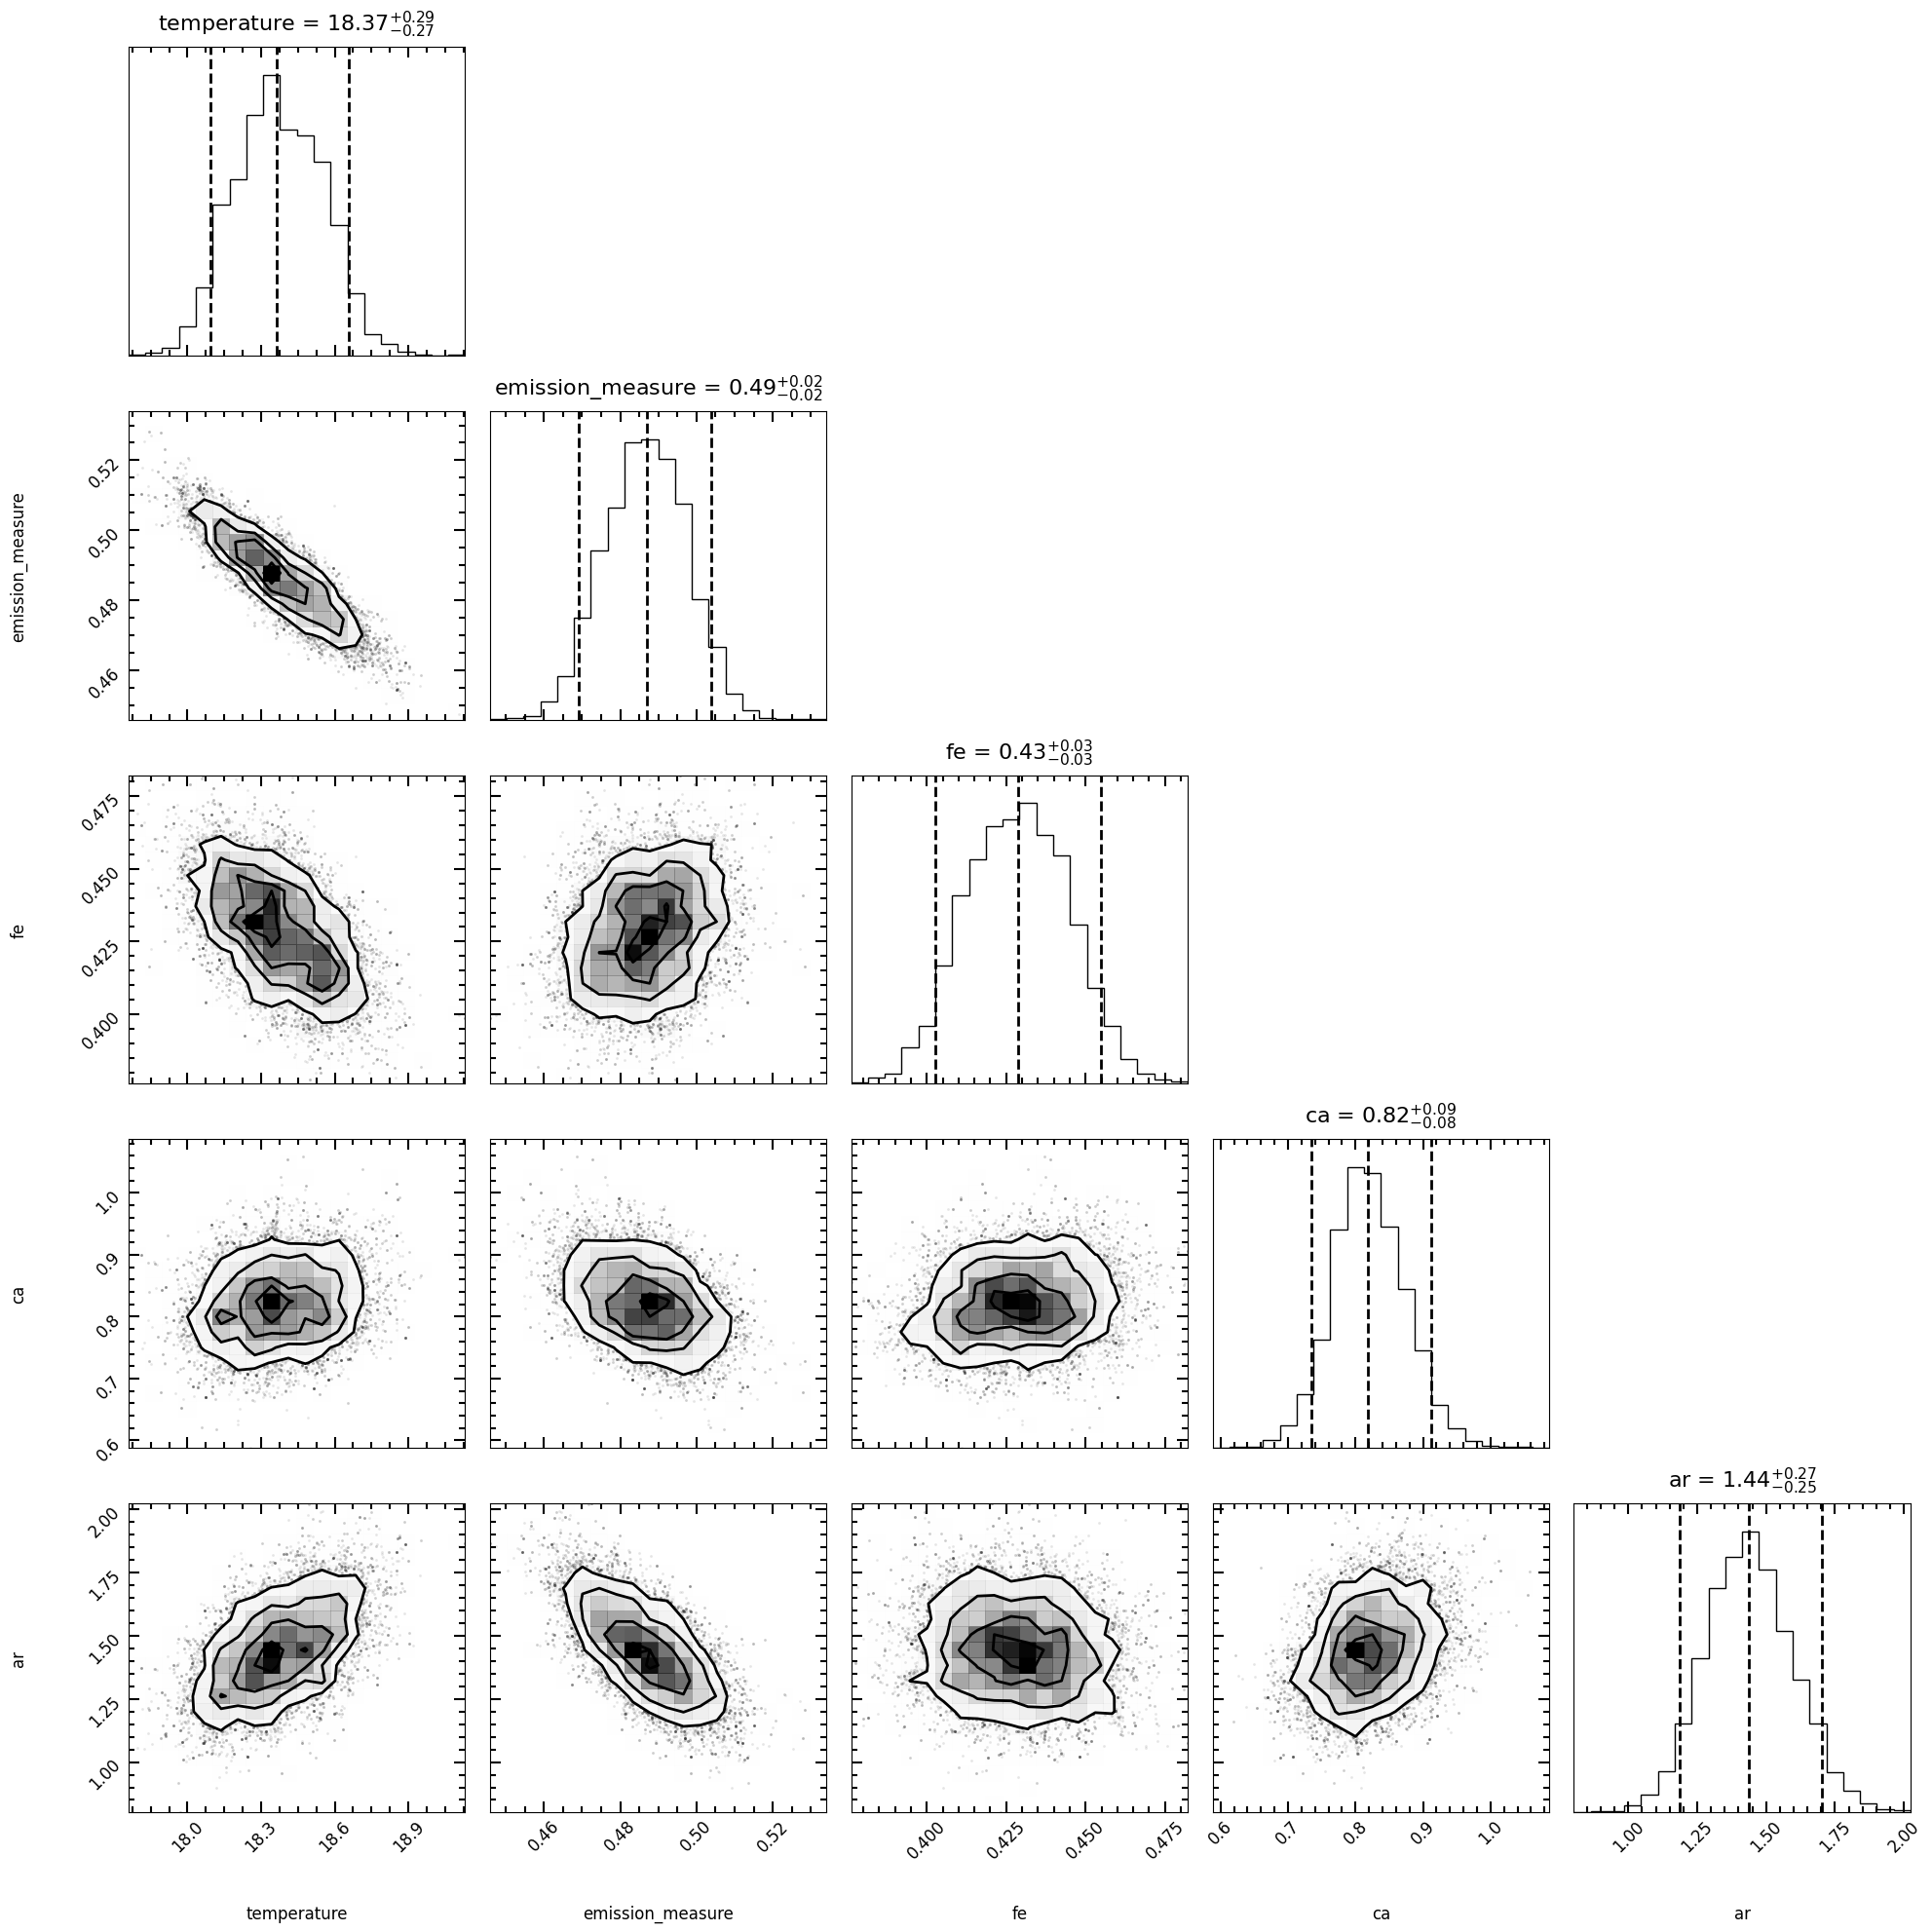

In [17]:
fig = plt.figure(layout="tight", figsize=(20, 20))
yap.corner_plot(fr, burnin=burn, fig=fig)
fig.savefig("solexs-corner.png", dpi=300)
plt.show()
plt.close(fig)

## The parameters seem to have converged to sensible posterior distributions. You can go back and add some different elements to see the effects.